C:\Users\f_voe\AppData\Roaming\Python\Python313\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


original train data
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500

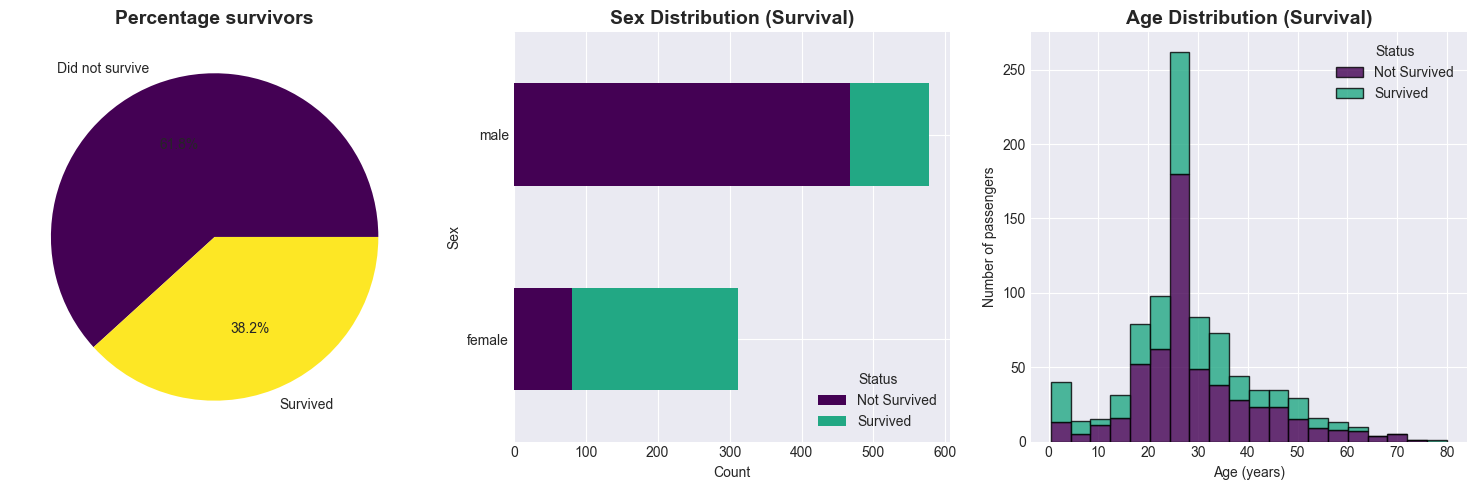

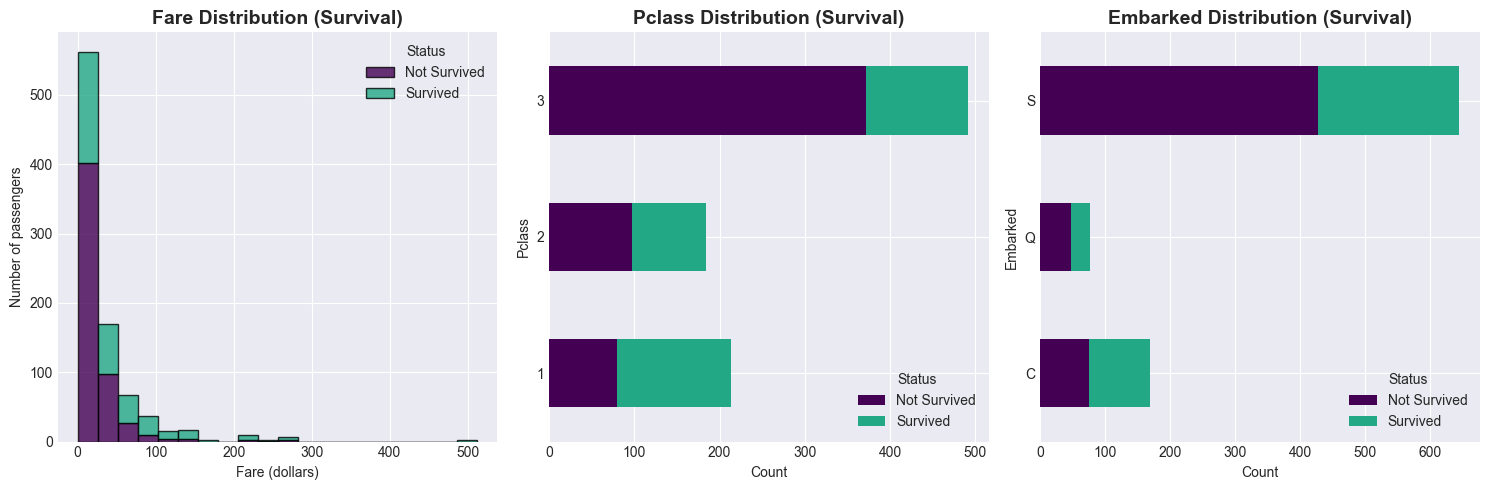

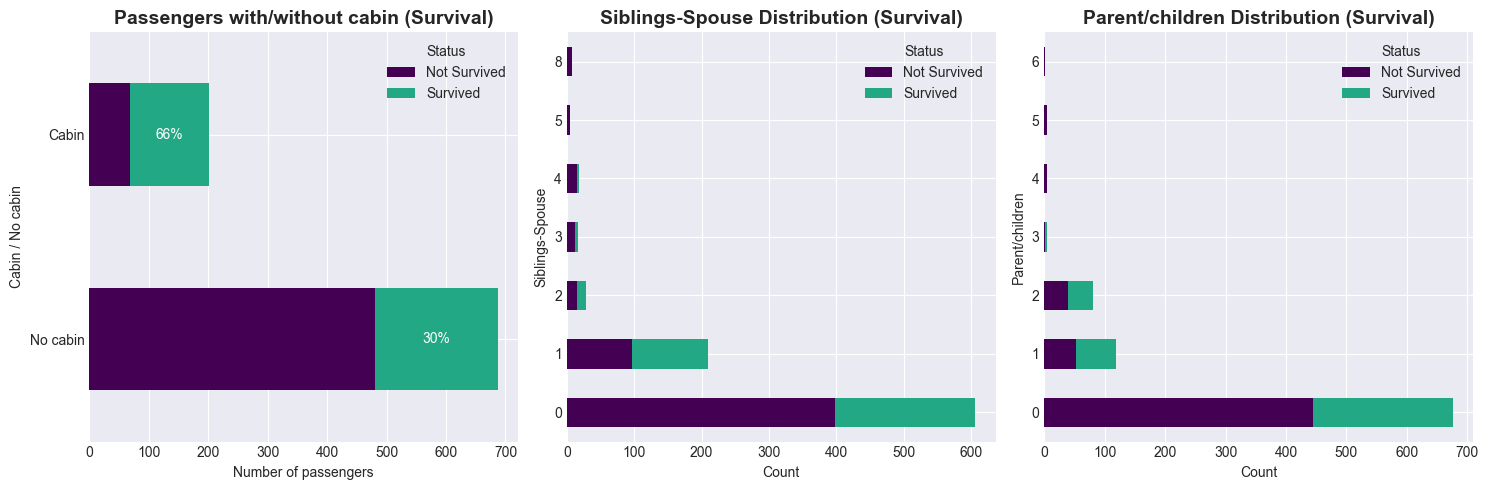

LogReg: ROC-AUC=0.868
DecisionTree: ROC-AUC=0.840
RandomForest: ROC-AUC=0.874
GradientBoosting: ROC-AUC=0.877
SVM_RBF: ROC-AUC=0.852
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best LR AUC: 0.8745148752832532
Best LR params: {'clf__C': np.float64(0.5336699231206307), 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best HGB AUC: 0.8855633886437049
Best HGB params: {'clf__l2_regularization': np.float64(0.5035273228673658), 'clf__learning_rate': np.float64(0.04444001265765016), 'clf__max_bins': 153, 'clf__max_depth': 7, 'clf__max_iter': 800, 'clf__min_samples_leaf': 46}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best RF AUC (randomized): 0.8801252980069354
Best RF params (randomized): {'clf__bootstrap': True, 'clf__ccp_alpha': np.float64(0.0004458616469407121), 'clf__class_weight': None, 'clf__max_depth': 15, 'clf__max_features': 0.9, 'clf__min_samples_leaf': 5, 'clf__min_samples_spli

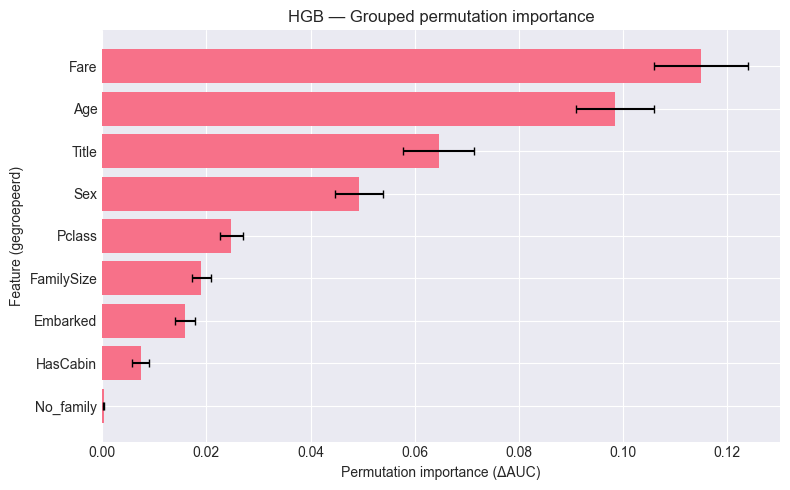

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_hist_gradient_boosting  # no-op in newer sklearn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

from scipy.stats import randint, uniform, loguniform


# visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')

sns.set_palette("husl")

# Load data
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')

# Initial data exploration
train = train_original.copy()


print("original train data")
print(train.head())
print(train.info())
print(f"NaN values in train- Age: {train["Age"].isna().sum()}")
print(f"NaN values in train- Embarked: {train["Embarked"].isna().sum()}")
print(f"NaN values in train-Cabin: {train["Cabin"].isna().sum()}")


# Preparing train data for plots

train["Age_missing"] = train["Age"].isna().astype(int)
train["Age"]= train["Age"].fillna(train["Age"].median())
train["Cabin"]= train["Cabin"].fillna("No cabin")
train['Title'] = train['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
train = train.dropna(subset=["Embarked"])


# Plots to explore data
fig = plt.figure(figsize=(15, 5))

# plot 1: Survivors - non-survivors
ax1 = plt.subplot(1, 3, 1)
survivor_counts = train['Survived'].map({0: 'Did not survive', 1: 'Survived'}).value_counts()
colors_viridis = plt.cm.viridis(np.linspace(0, 1, len(survivor_counts)))
ax1.pie(survivor_counts.values, labels=survivor_counts.index, autopct='%1.1f%%', 
        colors=colors_viridis)
ax1.set_title('Percentage survivors', fontsize=14, fontweight='bold')

# plot 2 Distribution passengers by sex and survival
ax2 = plt.subplot(1, 3, 2)
sex_surv_counts = train.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
colors = ['#440154FF', '#22A884FF']  
sex_surv_counts.plot(kind='barh', stacked=True, color=colors, ax=ax2)

ax2.set_xlabel('Count')
ax2.set_ylabel('Sex')
ax2.set_title('Sex Distribution (Survival)', fontsize=14, fontweight='bold')
ax2.legend(['Not Survived', 'Survived'], title='Status')

# plot 3 Distribution passengers by age and survival
ax3 = plt.subplot(1, 3, 3)
ages_survived = train[train['Survived'] == 1]['Age']
ages_not_survived = train[train['Survived'] == 0]['Age']
ax3.hist(
    [ages_not_survived, ages_survived],
    bins=20,
    stacked=True,
    color=['#440154FF', '#22A884FF'], 
    edgecolor='black',
    label=['Not Survived', 'Survived'],
    alpha=0.8
)

ax3.set_title('Age Distribution (Survival)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of passengers')
ax3.set_xlabel('Age (years)')
ax3.legend(title="Status")


plt.tight_layout()
plt.show()

# second row of plots, plot 4-6
fig = plt.figure(figsize=(15, 5))
# plot 4 Distribution passengers by fare and survival
ax4 = plt.subplot(1, 3, 1)
fare_survived = train[train['Survived'] == 1]['Fare']
fare_not_survived = train[train['Survived'] == 0]['Fare']
ax4.hist(
    [fare_not_survived, fare_survived],
    bins=20,
    stacked=True,
    color=['#440154FF', '#22A884FF'], 
    edgecolor='black',
    label=['Not Survived', 'Survived'],
    alpha=0.8
)

ax4.set_title('Fare Distribution (Survival)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of passengers')
ax4.set_xlabel('Fare (dollars)')
ax4.legend(title="Status")

# plot 5 Distribution passengers by Pclass and survival
ax5 = plt.subplot(1, 3, 2)
pclass_surv_counts = train.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0)
colors = ['#440154FF', '#22A884FF']  
pclass_surv_counts.plot(kind='barh', stacked=True, color=colors, ax=ax5)

ax5.set_xlabel('Count')
ax5.set_ylabel('Pclass')
ax5.set_title('Pclass Distribution (Survival)', fontsize=14, fontweight='bold')
ax5.legend(['Not Survived', 'Survived'], title='Status')

# plot 6 Distribution passengers by Embarked and survival
ax6 = plt.subplot(1, 3, 3)
embarked_surv_counts = train.groupby(['Embarked', 'Survived']).size().unstack(fill_value=0)
colors = ['#440154FF', '#22A884FF']  
embarked_surv_counts.plot(kind='barh', stacked=True, color=colors, ax=ax6)  
ax6.set_xlabel('Count')
ax6.set_ylabel('Embarked')
ax6.set_title('Embarked Distribution (Survival)', fontsize=14, fontweight='bold')
ax6.legend(['Not Survived', 'Survived'], title='Status')

plt.tight_layout()
plt.show()

# plot 7 - 9  
# plot 7 Distribution passengers by cabin or not
fig = plt.figure(figsize=(15, 5))
ax7 = plt.subplot(1, 3, 1)
train['HasCabin'] = pd.Categorical(
    np.where(
         train['Cabin'].eq('No cabin'),
        'No cabin', 'Cabin'
    ),
    categories=['No cabin', 'Cabin'],
    ordered=True
)
counts = (train.groupby(['HasCabin', 'Survived'], observed = True)
            .size()
            .unstack(fill_value=0)
            .rename(columns={0:'Not Survived', 1:'Survived'}))
counts.plot(kind='barh', stacked=True,
            color=['#440154FF', '#22A884FF'], ax=ax7)

ax7.set_xlabel('Number of passengers')
ax7.set_ylabel('Cabin / No cabin')
ax7.set_title('Passengers with/without cabin (Survival)', fontsize=14, fontweight='bold')
ax7.legend(title='Status', loc='best')

# % overlevenden in de balk
for i, (ns, s) in enumerate(counts[['Not Survived','Survived']].to_numpy()):
    total = ns + s
    if total > 0 and s > 0:
        ax7.text(ns + s/2, i, f"{s/total:.0%}",
                 ha='center', va='center', color='white', fontsize=10)


# plot 8 Distribution passengers by SibSp and survival

ax8 = plt.subplot(1, 3, 2)
sibsp_surv_counts = train.groupby(['SibSp', 'Survived']).size().unstack(fill_value=0)
colors = ['#440154FF', '#22A884FF']  
sibsp_surv_counts.plot(kind='barh', stacked=True, color=colors, ax=ax8)
ax8.set_xlabel('Count')
ax8.set_ylabel('Siblings-Spouse')
ax8.set_title('Siblings-Spouse Distribution (Survival)', fontsize=14, fontweight='bold')
ax8.legend(['Not Survived', 'Survived'], title='Status')        

# plot 9 Distribution passengers by Parch and survival
ax9 = plt.subplot(1, 3, 3)
parch_surv_counts = train.groupby(['Parch', 'Survived']).size().unstack(fill_value=0)
colors = ['#440154FF', '#22A884FF']  
parch_surv_counts.plot(kind='barh', stacked=True, color=colors, ax=ax9)
ax9.set_xlabel('Count')

ax9.set_ylabel('Parent/children')
ax9.set_title('Parent/children Distribution (Survival)', fontsize=14, fontweight='bold')
ax9.legend(['Not Survived', 'Survived'], title='Status')    
plt.tight_layout()
plt.show()

# Machine Learning part

class TitanicFeatureBuilder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # FamilySize & No_family
        sibsp = X.get('SibSp').fillna(0)
        parch = X.get('Parch').fillna(0)
        X['FamilySize'] = (sibsp + parch + 1).astype(int)
        X['No_family'] = (X['FamilySize'] == 1).astype(int)

        # HasCabin: 1 als Cabin nummer, anders 0)
        X['HasCabin'] = X['Cabin'].notna().astype(int)
        # Title uit Name
        name = X.get('Name', pd.Series('', index=X.index)).fillna('')
        X['Title'] = name.str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
        title_map = {
            "Mlle": "Miss",
            "Ms": "Miss",
            "Mme": "Mrs",
            "Lady": "Royalty",
            "Countess": "Royalty",
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Dr": "Officer",
            "Rev": "Officer",
            "Sir": "Royalty",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Dona": "Royalty"
        }
        X['Title'] = X['Title'].replace(title_map)
               
        return X




target = 'Survived'
num_feats = ['Age','Fare']
num_new  = ['FamilySize','No_family','HasCabin']
cat_feats = ['Pclass','Sex','Embarked']
cat_new  = ['Title']  


# Preprocessing
num = Pipeline([('imp', SimpleImputer(strategy='median'))])
cat = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ])

pre = ColumnTransformer(
    transformers=[
        ('num', num, num_feats + num_new),
        ('cat', cat, cat_feats + cat_new),
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

                       

# Eerste modelevaluatie met cross validation
models = {
    'LogReg': Pipeline([
        ('fe', TitanicFeatureBuilder()),
        ('pre', pre),
        ('scale', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=2000))]),
    'DecisionTree': Pipeline([
        ('fe', TitanicFeatureBuilder()),
        ('pre', pre),
        ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))]),
    'RandomForest': Pipeline([
        ('fe', TitanicFeatureBuilder()),
        ('pre', pre),
        ('clf', RandomForestClassifier(n_estimators=400, random_state=42))]),
    'GradientBoosting': Pipeline([
        ('fe', TitanicFeatureBuilder()),
        ('pre', pre),
        ('clf', GradientBoostingClassifier(random_state=42))]),
    'SVM_RBF': Pipeline([
        ('fe', TitanicFeatureBuilder()),
        ('pre', pre),
        ('scale', StandardScaler(with_mean=False)),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
}
df = train_original.copy()
X = df.drop(columns=[target]).copy()
y = df[target].astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipe in models.items():
    score = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc').mean()
    print(f'{name}: ROC-AUC={score:.3f}')

# Hyperparameter tuning voor drie beste modellen: logistic regression, GradientBoosting en RandomForest

set_config(transform_output="pandas")   

# Hyperparameter tuning Logistic Regression (model 1)

logit_pipe = Pipeline([
    ('fe', TitanicFeatureBuilder()),
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=5000))
])

logit_param_grid = [
    # L2
    {
        "clf__penalty": ["l2"],
        "clf__C": np.logspace(-3, 2, 12),
        "clf__solver": ["liblinear", "saga"]
    },
    # L1
    {
        "clf__penalty": ["l1"],
        "clf__C": np.logspace(-3, 2, 12),
        "clf__solver": ["liblinear", "saga"]
    },
    # Elastic Net (only with saga)
    {
        "clf__penalty": ["elasticnet"],
        "clf__C": np.logspace(-3, 2, 12),
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
    }
]


logit_grid = GridSearchCV(
    estimator=logit_pipe,
    param_grid=logit_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

logit_grid.fit(X, y)
print("Best LR AUC:", logit_grid.best_score_)
print("Best LR params:", logit_grid.best_params_)
best_logit = logit_grid.best_estimator_


# Hyperparameter tuning voor GradientBoosting (model 2)

hgb_pipe = Pipeline([
    ('fe', TitanicFeatureBuilder()),
    ('pre', pre),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])

hgb_param_dist = {
    "clf__learning_rate": loguniform(1e-3, 3e-1),
    "clf__max_iter": randint(200, 1200),          
    "clf__max_depth": [None, 3, 5, 7, 9],
    "clf__min_samples_leaf": randint(5, 200),
    "clf__l2_regularization": loguniform(1e-6, 10.0),
    "clf__max_bins": randint(128, 255)
}


hgb_rand = RandomizedSearchCV(
    estimator=hgb_pipe,
    param_distributions=hgb_param_dist,
    n_iter=200,                 
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

hgb_rand.fit(X, y)
print("Best HGB AUC:", hgb_rand.best_score_)
print("Best HGB params:", hgb_rand.best_params_)
best_hgb = hgb_rand.best_estimator_


# Hyperparameter tuning voor Random Forest (model 3)

rf_pipe = Pipeline([
    ('fe', TitanicFeatureBuilder()),
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
    ))
])

rf_param_dist = {
    "clf__n_estimators": randint(200, 1200),             # aantal bomen
    "clf__max_depth": [None] + list(range(3, 21)),       # dieptebeperking
    "clf__min_samples_split": randint(2, 50),
    "clf__min_samples_leaf": randint(1, 30),
    "clf__max_features": ["sqrt", "log2", None, 0.5, 0.7, 0.9], 
    "clf__bootstrap": [True, False],
    "clf__class_weight": [None, "balanced"],             
    "clf__ccp_alpha": loguniform(1e-6, 1e-1)           
    
}

rf_rand = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=200,                
    scoring="roc_auc",         
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

rf_rand.fit(X, y)
print("Best RF AUC (randomized):", rf_rand.best_score_)
print("Best RF params (randomized):", rf_rand.best_params_)
best_rf = rf_rand.best_estimator_


# Winner: HGBoost has hightest score
winner = hgb_rand.best_estimator_ 

# Predict on test set and save for submission
df_test = test_original.copy()
test_pred = winner.predict(df_test).astype(int)
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": test_pred
})
submission.to_csv("submission.csv", index=False)

# Feature importance

fe  = best_hgb.named_steps['fe']    
pre = best_hgb.named_steps['pre']   
clf = best_hgb.named_steps['clf']   

Z  = fe.transform(X)                 
Xt = pre.transform(Z)       
try:
    colnames = pre.get_feature_names_out()
    
except Exception:
    colnames = np.array([f"f{i}" for i in range(Xt.shape[1])])
    
Xt_df = pd.DataFrame(Xt, columns=colnames, index=getattr(X, "index", None))

# alle OHE-kolommen van dezelfde bronfeature bij elkaar zetten
#    Detecteren welke ColumnTransformer-stappen OHE zijn.
is_ohe_step = {}
for step_name, trans, cols in pre.transformers_:
    flag = False
    if isinstance(trans, OneHotEncoder):
        flag = True
    elif isinstance(trans, Pipeline):
        flag = any(isinstance(s, OneHotEncoder) for _, s in trans.steps)
    is_ohe_step[step_name] = flag

def base_feature_name(step, rest): 
    """
    Maak een groepsnaam uit transformer-step en featuredeel.
    Voor OHE: strip de categorie door op de LAATSTE underscore te splitsen.
    Voor niet-OHE: neem rest zoals is.
    """
    if is_ohe_step.get(step, False):
        # 'Sex_female' -> 'Sex'  
        if '_' in rest:
            return f"{step}::{rest.rsplit('_', 1)[0]}"
        else:
            return f"{step}::{rest}"
    else:
        return f"{step}::{rest}"

groups = {}
for c in Xt_df.columns:
    if '__' in c:
        step, rest = c.split('__', 1)   # 'cat__Sex_female' -> step='cat', rest='Sex_female'
    else:
        step, rest = 'pre', c           # als er geen prefix is
    g = base_feature_name(step, rest)
    groups.setdefault(g, []).append(c)

# Grouped permutation importance: permuteer ALLE kolommen in een groep tegelijk
def grouped_permutation_importance(clf, Xdf, y, groups, n_repeats=30, random_state=42):
    rng = np.random.default_rng(random_state)
    # baseline AUC
    p_base = clf.predict_proba(Xdf)[:, 1]
    base_auc = roc_auc_score(y, p_base)

    out = []
    for gname, cols in groups.items():
        drops = []
        for r in range(n_repeats):
            Xp = Xdf.copy()
            perm = rng.permutation(len(Xp))
            # permuteer alle kolommen in de groep met DEZELFDE permutatie
            Xp[cols] = Xp[cols].iloc[perm].to_numpy()
            auc = roc_auc_score(y, clf.predict_proba(Xp)[:, 1])
            drops.append(base_auc - auc)
        out.append((gname, np.mean(drops), np.std(drops)))
    imp = (pd.DataFrame(out, columns=['group', 'imp_mean', 'imp_std'])
             .sort_values('imp_mean', ascending=False)
             .reset_index(drop=True))
    return imp

imp_grouped = grouped_permutation_importance(clf, Xt_df, y, groups, n_repeats=30, random_state=42)

# Opruimen van namen: 'cat::Sex' -> 'Sex'
imp_grouped['feature'] = imp_grouped['group'].str.split('::', n=1).str[-1]
imp_grouped = imp_grouped[['feature', 'imp_mean', 'imp_std']]

print(imp_grouped.head(20))



# sorteer van klein naar groot zodat de hoogste bovenaan komt in barh
imp_plot = imp_grouped.sort_values('imp_mean', ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(
    imp_plot['feature'],
    imp_plot['imp_mean'],
    xerr=imp_plot['imp_std'],
    capsize=3
)
ax.set_xlabel('Permutation importance (ΔAUC)')
ax.set_ylabel('Feature')
ax.set_title('HGB — permutation importance')
plt.tight_layout()
plt.show()

